## 포트폴리오 최적화
* 샤프비율과 같은 평균-분산 효용함수를 극대화하는 투자자산의 비중을 구해야 함
* 샤프비율이 가장 높은 최적 포트폴리오는 자본시장선과 효율적 포트폴리오 접선 위에 위치함

### 최적화 예제 : y = x + 1
* 제약조건 : x >= 3

* 목적함수 : y = x + 1
* 초깃값 : -1.0
* 제약조건(x값의 범위) : -1.0 ~ 6.0
* 최적화 메소드 : SLSQP

In [4]:
from scipy.optimize import minimize

def objective(x):
    return x+1

# 제약식은 0값을 기준으로 식을 변형해서 옮김. 따라서 x >= 3은 (x-3) > 0 과 같음
def constraint(x):
    return x-3

# 초깃값은 -1, 리스트 형태로 생성
x0 = [-1]

# 해의 범위는 튜플로 생성
b = (-1, 6)

# 여러개의 변수에 대한 범위를 정하려면 여러개를 튜플에 넣어야 함
bnd = (b, )

In [6]:
# 제약조건을 딕셔너리로 생성
# type : 'eq' or 'ineq'. eq는 제약식 함수값으 0과 같다는 의미
# fun : 제약식 함수
con = {"type":"ineq", "fun":constraint}

sol = minimize(objective, x0, method="SLSQP", bounds=bnd, constraints=con)

print(sol)  # y값을 최소화하는 값은 x에 담겨있음

     fun: array([4.])
     jac: array([1.])
 message: 'Optimization terminated successfully'
    nfev: 4
     nit: 2
    njev: 2
  status: 0
 success: True
       x: array([3.])


In [12]:
import numpy as np
import pandas as pd
from pandas_datareader import data as web
import matplotlib.pyplot as plt
import matplotlib as mpl

# 다섯개 종목으로 비중을 바꿔가며 포트폴리오 생성
tickers = ["AAPL", "F", "AMZN", "GE", "TSLA"]
pxclose = pd.DataFrame()
for t in tickers:
    pxclose[t] = web.DataReader(t, data_source="yahoo", start="01-01-2019", end="31-12-2019")["Adj Close"]
ret_daily = pxclose.pct_change()
ret_annual = ret_daily.mean() * 250
cov_daily = ret_daily.cov()
cov_annual = cov_daily * 250

In [10]:
from scipy.optimize import minimize

# 포트폴리오 분산(위험) 함수 : 최소화
def obj_variance(weights, covmat):
    return np.sqrt(weights.T @ covmat @ weights)  # @ : 행렬곱

covmat = cov_daily * 250  # 일간수익률 공분산을 연간으로 환산

# 20%씩 분산
weights = np.array([0.2, 0.2, 0.2, 0.2, 0.2])

# 각 종목의 투자 비중 한도는 0 ~ 100%
bnds = ((0, 1), (0, 1), (0, 1), (0, 1), (0, 1))

cons = {"type":"eq", "fun": lambda x: np.sum(x)-1}

res = minimize(obj_variance, weights, (covmat), method="SLSQP", bounds=bnds, constraints=cons)
print(res)  # x : 최적의 포트폴리오 상에서 각 종목에 분배할 퍼센트

     fun: 0.19552891543751635
     jac: array([0.19526334, 0.19583519, 0.19543232, 0.19544312, 0.19565263])
 message: 'Optimization terminated successfully'
    nfev: 54
     nit: 9
    njev: 9
  status: 0
 success: True
       x: array([0.21372253, 0.30339345, 0.41449485, 0.02187806, 0.04651111])


In [14]:
p_returns = []
p_volatility = []

n_assets = len(tickers)

n_ports = 30000  # 포트폴리오 갯수

for s in range(n_ports):
    wgt = np.random.random(n_assets)  # 종목별 매수비중
    wgt /= np.sum(wgt)

    # 기대수익률 계산
    ret = np.dot(wgt, ret_annual)

    # 변동성 계산
    vol = np.sqrt(np.dot(wgt.T, np.dot(cov_annual, wgt)))

    p_returns.append(ret)
    p_volatility.append(vol)

# visualizing
p_volatility = np.array(p_volatility)
p_returns = np.array(p_returns)

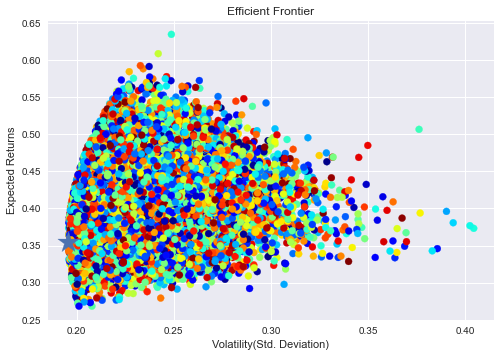

In [16]:
# 최적 포트폴리오를 plot상에 표시

rets = np.sum(ret_daily.mean() * res['x']) * 250

# 최소분산포트폴리오의 위험
vol = np.sqrt(res['x'].T @ covmat @ res['x'])

colors = np.random.randint(0, n_ports, n_ports)

plt.style.use('seaborn')
plt.scatter(p_volatility, p_returns, c=colors, marker='o', cmap=mpl.cm.jet)
plt.scatter(vol, rets, marker='*', s=500, alpha=1.0)
plt.xlabel("Volatility(Std. Deviation)")
plt.ylabel("Expected Returns")
plt.title("Efficient Frontier")
plt.show()

# 왼쪽 아래에 별표 위치가 최소분산포트폴리오의 위치

In [17]:
# 샤프비율 최적화를 통한 최소분산포트폴리오의 투자 비중 계산
# 샤프비율은 이전과 달리 최대화가 목적임

from scipy.optimize import minimize

def obj_sharp(weights, returns, covmat, rf):
    ret = np.dot(weights, returns)
    vol = np.sqrt(np.dot(weights.T, np.dot(covmat, weights)))

    return 1/((ret-rf) / np.sqrt(vol))

In [19]:
n_assets = len(tickers)
covmat = cov_daily*250

# 무위험수익률
rf = 0.01

# 초기 투자 비중은 균등하게
weights = np.ones([n_assets]) / n_assets

bnds = tuple((0., 1.) for i in range(n_assets))

cons = {'type': 'eq', 'fun': lambda w:np.sum(w) - 1}

res = minimize(obj_sharp, weights, (ret_annual, covmat, rf), method="SLSQP", bounds=bnds, constraints=cons)
print(res)

     fun: 0.7773785409231362
     jac: array([-0.40061451, -0.22166819, -0.07073736, -0.40032232, -0.16600382])
 message: 'Optimization terminated successfully'
    nfev: 30
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([9.75250800e-01, 5.29090660e-17, 2.71050543e-17, 2.47492004e-02,
       1.92987987e-17])


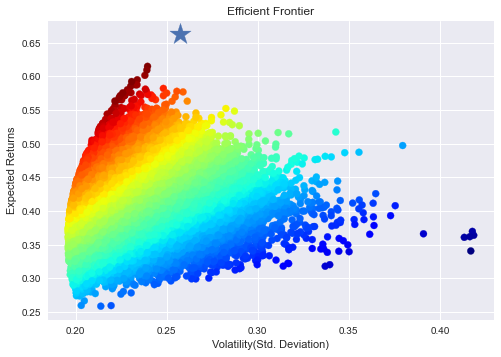

In [20]:
p_returns = []
p_volatility = []
p_weights = []

n_assets = len(tickers)
n_ports = 30000  # 포트폴리오 갯수

for s in range(n_ports):
    wgt = np.random.random(n_assets)  # 종목별 매수비중
    wgt /= np.sum(wgt)

    # 기대수익률 계산
    ret = np.dot(wgt, ret_annual)

    # 변동성 계산
    vol = np.sqrt(np.dot(wgt.T, np.dot(cov_annual, wgt)))

    p_returns.append(ret)
    p_volatility.append(vol)
    p_weights.append(wgt)

rets = np.sum(ret_daily.mean()*res['x']) * 250
vol = np.sqrt(res['x'].T @ covmat @ res['x'])

p_volatility = np.array(p_volatility)
p_returns = np.array(p_returns)

colors = p_returns/p_volatility
plt.style.use('seaborn')
plt.scatter(p_volatility, p_returns, c=colors, marker='o', cmap=mpl.cm.jet)
plt.scatter(vol, rets, marker='*', s=500, alpha=1.0)
plt.xlabel("Volatility(Std. Deviation)")
plt.ylabel("Expected Returns")
plt.title("Efficient Frontier")
plt.show()

# 샤프 비율이 최대화됨에 따라 고위험 고수익의 최적 포트폴리오가 구성됨